In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding =4), #cifar 10 image size : 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train=True, 
                download= True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                download=True, transform= transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96,
                                          shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96,
                                         shuffle =True, num_workers =2)

#num_workers =2 인지 4인지 or batch_size test의 경우는 왜 100인지?

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = F.relu6(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [5]:
class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [6]:
net = MobileNetV2()
net = net.to(device)

if device == 'cuda':
#     net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [17]:
# net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.045
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00004)

loss_list_train = []
accuracy_list_train = []

loss_list_test = []
accuracy_list_test =[]

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)#예측값과 실제 타깃값
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())
            
    accuracy_list_train.append(100. * correct / total)
    print('\nTotal benign train accuarcy:', 100. * correct / total)
    loss_list_train.append(train_loss)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        
    accuracy_list_test.append(100. * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    loss_list_test.append(loss)
    print('Test average loss:', loss / total)    

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


        
#learning rate를 바꾸기
def adjust_learning_rate(optimizer, epoch):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch <=150 and epoch != 0:
            param_group['lr'] = lr * 0.98
        print(param_group['lr'])

In [18]:
for epoch in range(0, 150):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

0.045

[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.9375
Current benign train loss: 0.12915895879268646

Current batch: 100
Current benign train accuracy: 0.9375
Current benign train loss: 0.2070772796869278

Current batch: 200
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.12173139303922653

Current batch: 300
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.2132483720779419

Current batch: 400
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.24257726967334747

Current batch: 500
Current benign train accuracy: 0.96875
Current benign train loss: 0.18370221555233002

Total benign train accuarcy: 91.44
Total benign train loss: 126.54217211902142

[ Test epoch: 0 ]

Test accuarcy: 88.53
Test average loss: 0.0036661081656813622
Model Saved!
0.0441

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.158567786216


Current batch: 200
Current benign train accuracy: 0.9375
Current benign train loss: 0.14252270758152008

Current batch: 300
Current benign train accuracy: 0.9375
Current benign train loss: 0.24968576431274414

Current batch: 400
Current benign train accuracy: 0.9375
Current benign train loss: 0.14882057905197144

Current batch: 500
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.1629706472158432

Total benign train accuarcy: 93.906
Total benign train loss: 89.61176094040275

[ Test epoch: 9 ]

Test accuarcy: 88.09
Test average loss: 0.004273506456613541
Model Saved!
0.036768276309939604

[ Train epoch: 10 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.10157275199890137

Current batch: 100
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.15992338955402374

Current batch: 200
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.10060926526784897

Current batch:


Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.0479920357465744

Total benign train accuarcy: 95.726
Total benign train loss: 61.34075800329447

[ Test epoch: 18 ]

Test accuarcy: 89.89
Test average loss: 0.0037714375909417867
Model Saved!
0.030655468090795137

[ Train epoch: 19 ]

Current batch: 0
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.1125757172703743

Current batch: 100
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.10835260152816772

Current batch: 200
Current benign train accuracy: 0.9375
Current benign train loss: 0.13185088336467743

Current batch: 300
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.16686566174030304

Current batch: 400
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.09347463399171829

Current batch: 500
Current benign train accuracy: 0.96875
Current benign train loss: 0.09891264


Test accuarcy: 90.97
Test average loss: 0.003663162472844124
Model Saved!
0.02555892791775266

[ Train epoch: 28 ]

Current batch: 0
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.1268017739057541

Current batch: 100
Current benign train accuracy: 0.96875
Current benign train loss: 0.043824151158332825

Current batch: 200
Current benign train accuracy: 0.96875
Current benign train loss: 0.07358122617006302

Current batch: 300
Current benign train accuracy: 0.96875
Current benign train loss: 0.14079229533672333

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.06539802998304367

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05368581414222717

Total benign train accuarcy: 97.08
Total benign train loss: 43.16723885759711

[ Test epoch: 28 ]

Test accuarcy: 91.09
Test average loss: 0.003515017919242382
Model Saved!
0.025047749359397607

[ Train epoch: 29 ]




Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.04018527269363403

Current batch: 100
Current benign train accuracy: 0.96875
Current benign train loss: 0.0566873736679554

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.015286373905837536

Current batch: 300
Current benign train accuracy: 0.96875
Current benign train loss: 0.08208111673593521

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.041271548718214035

Current batch: 500
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.08675771206617355

Total benign train accuarcy: 98.018
Total benign train loss: 28.48829548759386

[ Test epoch: 37 ]

Test accuarcy: 91.48
Test average loss: 0.0037911042839288713
Model Saved!
0.020883504974794645

[ Train epoch: 38 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.033600788563489914

C


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.02157900296151638

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.006861938629299402

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00696936622262001

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.030518824234604836

Total benign train accuarcy: 98.534
Total benign train loss: 21.61213916284032

[ Test epoch: 46 ]

Test accuarcy: 91.89
Test average loss: 0.0039053976722061633
Model Saved!
0.017411575538168883

[ Train epoch: 47 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.0710008516907692

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.019319036975502968

Current batch: 200
Current benign train accuracy: 0.96875
Current benign train loss: 0.033776894211769104

Current batch: 300
Current b


Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.011088952422142029

Total benign train accuarcy: 99.098
Total benign train loss: 13.372558705508709

[ Test epoch: 55 ]

Test accuarcy: 91.75
Test average loss: 0.004208154804632068
Model Saved!
0.01451686214010837

[ Train epoch: 56 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.03198493644595146

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.007938636466860771

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.008441106416285038

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.029704006388783455

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.004853388760238886

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.035531286150217056

Total benign train 


Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.008026082068681717

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.008799931965768337

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.015060174278914928

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.008070307783782482

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.02835242636501789

Total benign train accuarcy: 99.516
Total benign train loss: 7.7094983224524185

[ Test epoch: 65 ]

Test accuarcy: 92.05
Test average loss: 0.004142014390416443
Model Saved!
0.011861333296017903

[ Train epoch: 66 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.008544692769646645

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.004280974622815847

Current batch: 200
Current benign


Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0014404206303879619

Total benign train accuarcy: 99.642
Total benign train loss: 5.64975548669463

[ Test epoch: 74 ]

Test accuarcy: 92.32
Test average loss: 0.0041577372196130455
Model Saved!
0.009889360091434759

[ Train epoch: 75 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.007815487682819366

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.004136418458074331

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.002817845204845071

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.002737712115049362

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.009053893387317657

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0027691267896443605

Total benign train accuarcy: 99.72
Total benign train loss: 4


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0036150345113128424

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.014544952660799026

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.004190524108707905

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0023440991062670946

Total benign train accuarcy: 99.774
Total benign train loss: 3.7272249198067584

[ Test epoch: 84 ]

Test accuarcy: 92.59
Test average loss: 0.004122095120325684
Model Saved!
0.008080327208230282

[ Train epoch: 85 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.02090911567211151

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0038922273088246584

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.003674432635307312

Current batch: 300
Current ben


Test accuarcy: 92.99
Test average loss: 0.004215991916507482
Model Saved!
0.006736954727141358

[ Train epoch: 94 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0020659384317696095

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.002814294071868062

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0013483274960890412

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.005181869957596064

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.008121698163449764

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0015039130812510848

Total benign train accuarcy: 99.864
Total benign train loss: 2.3556864234342356

[ Test epoch: 94 ]

Test accuarcy: 92.89
Test average loss: 0.004194983451813459
Model Saved!
0.006602215632598531

[ Train epoch: 95 ]

Current batch: 0
Current benign train accurac


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.006890298333019018

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0005838018259964883

Total benign train accuarcy: 99.91
Total benign train loss: 1.8341206640179735

[ Test epoch: 103 ]

Test accuarcy: 92.87
Test average loss: 0.004123131448403001
Model Saved!
0.0055045825087797155

[ Train epoch: 104 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0005038322415202856

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0014724460197612643

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.01226931344717741

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0016977912746369839

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.000323549349559471

Current batch: 500
Current benign train ac


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0022517263423651457

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.000530547637026757

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0006049243384040892

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.003291462315246463

Total benign train accuarcy: 99.932
Total benign train loss: 1.4408441002997279

[ Test epoch: 113 ]

Test accuarcy: 92.92
Test average loss: 0.004176773075759411
Model Saved!
0.004497644681192735

[ Train epoch: 114 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0009077966678887606

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.007549293339252472

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0004544974071905017

Current batch: 300
Current benign train accuracy: 1.0
Cu


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00011343162623234093

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.008423964492976665

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0005649476661346853

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.007143816445022821

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0028675440698862076

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0006633782177232206

Total benign train accuarcy: 99.95
Total benign train loss: 1.0866927604438388

[ Test epoch: 123 ]

Test accuarcy: 92.83
Test average loss: 0.004262727486714721
Model Saved!
0.003674903164044994

[ Train epoch: 124 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.010006208904087543

Current batch: 100
Current benign train acc


Total benign train accuarcy: 99.958
Total benign train loss: 1.0766510550420207

[ Test epoch: 132 ]

Test accuarcy: 92.92
Test average loss: 0.004259767286106944
Model Saved!
0.0030639422890675204

[ Train epoch: 133 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0009209319832734764

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0022172171156853437

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0006376638193614781

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.001158626633696258

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.001795107964426279

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00010424403444631025

Total benign train accuarcy: 99.964
Total benign train loss: 0.8346806348927203

[ Test epoch: 133 ]

Test accuarcy: 92.95
Test average loss: 0.0041601420904


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00011642603203654289

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00022794977121520787

Total benign train accuarcy: 99.956
Total benign train loss: 0.8415248856836115

[ Test epoch: 142 ]

Test accuarcy: 92.93
Test average loss: 0.004199957626312971
Model Saved!
0.0025034639262698543

[ Train epoch: 143 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 6.185282836668193e-05

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0006829306948930025

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0007102449890226126

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0038844700902700424

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.005839629098773003

Current batch: 500
Current benign train accuracy: 1

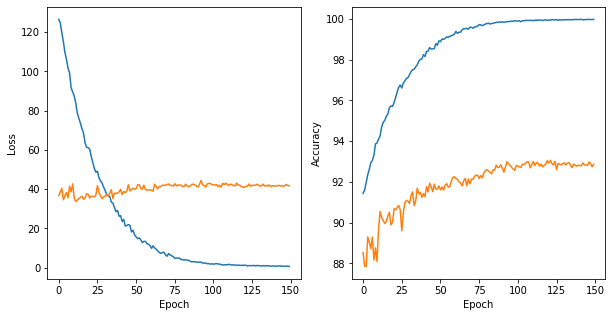

In [19]:
epochs = np.arange(0,150)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1) 
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.plot(epochs,loss_list_train) 
plt.plot(epochs,loss_list_test)
plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(epochs, accuracy_list_train) 
plt.plot(epochs, accuracy_list_test) 
plt.show()